# **Data Cleaning**

## Objectives

Clean data in preparation for determining the most important features.

## Inputs

1. House_prices_records.csv
2. Inherited_houses.csv

## Outputs

3. House_prices_records_clean.csv
4. Inherited_houses_clean.csv

## Comments
Note that this step is separate from feature engineering. Our aim in this notebook is to produce a clean data set with no missing information. The aim in the Feature engineering notebook is to examine the most suitable way of preparing our data for the price correlation study and to train the model.

We will using this opportunity to apply the same cleaning tools to the Inherited_houses.csv data set as we will need to do that before we can run them through the model.

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir


'/workspace/Heritage-Housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")


You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir


'/workspace/Heritage-Housing'

# Load Data

Section 1 content

In [4]:
import numpy as np
import pandas as pd

house_prices_df = pd.read_csv(
    f"outputs/datasets/collection/house_prices_records.csv"
    )
inherited_houses_df = pd.read_csv(
    f"outputs/datasets/collection/inherited_houses.csv"
    )


---

## Data cleaning

Following investigations the below cleaning strategy was implemented.


#### Remove columns missing substantial amounts of data.
EnclosedPorch and WoodDeckSF have 90.7% and 89.4% of the data missing. Where present it does not vary significantly across the range of the houses so will have limited predictive power. Imputing such a high proportion of missing data is a riskier option than removing these features entirely. 


In [5]:
from feature_engine.selection import DropFeatures


def drop_features(df):
    """
    Function to remove EnclosedPorch and WoodDeckSF from data set
    """
    imputer = DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])
    df_removed_columns = imputer.fit_transform(df)
    return df_removed_columns


Apply drop_features function to house_prices_df and check columns have been removed. Data set should now have 22 columns rather than 24.

In [6]:
house_prices_df= drop_features(house_prices_df)
house_prices_df.shape


(1460, 22)

Apply drop_features function to inherited_houses_df and check columns have been removed. Data set Should now have 21 columns rather than 24.

In [7]:
inherited_houses_df = drop_features(inherited_houses_df)
inherited_houses_df.shape


(4, 21)

---

#### Impute Missing data for remaining columns.

Following removal of these two columns we can review the missing data. 

In [ ]:
def EvaluateMissingData(df):
    """
    Function to evaluate data with missing values.
    This function is taken from The code institute Churnometer walkthrough
    project. https://github.com/Code-Institute-Solutions/churnometer/blob/main/
    jupyter_notebooks/03%20-%20DataCleaning.ipynb
    """
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                      data={"RowsWithMissingData": missing_data_absolute,
                            "PercentageOfDataset": missing_data_percentage,
                            "DataType": df.dtypes}
                              ).sort_values(
                                  by=['PercentageOfDataset'], ascending=False
                                  ).query("PercentageOfDataset > 0"))

    return df_missing_data


df_missing_data = EvaluateMissingData(house_prices_df)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data


* There are 7 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


In [9]:
rows_without_missing_data = house_prices_df.dropna()
rows_without_missing_data.shape[0]


797

We can see that there are still seven columns missing data and 797 rows without missing data. This is a significant improvement but leaves nearly 40% of rows with missing data. We can see if this can be improved by experimenting with imputing the missing data. We will only need to impute missing data for the house_prices_df data set. There is no missing data in the inherited houses set.

We have seen in the Data Inspection Notebook that the missing data is missing completely at random (MCAR). We cannot impute the data based on data in another feature, so we will need to impute it based on data from the same feature in different observations.

Our imputation method needs to reflect the existing distribution of data so it doesn't distort our data study or model. Features related to measurements and dates are numeric and either positively or negatively skewed, whilst quality ratings are categorical and evenly distributed. We will apply different methodologies to each and analyse the effects of the imputation.

* Numeric variables - LotFrontage, BedroomAbvGr, 2ndFlrSF, GarageYrBlt, MasVnrArea.
* Categorical variables - GarageFinish, BsmtFinType1.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


def DataCleaningEffect(df_original, df_cleaned, variables_applied_with_method):
    """
    Function to visualize data cleaning effect. This function is taken from the
    code institute Data Analysis & Machine Learning Toolkit, Feature Engine
    Unit9: Custom Functions. The function layers visualisations of the data
    before and after imputations so we can see the difference.
    https://learn.codeinstitute.net/courses/course-v1:
    code_institute+CI_DA_ML+2021_Q4/courseware/
    1f851533cd6a4dcd8a280fd9f37ef4/bb0bf41fb8744b46813c0f52a74b9b11/
    """
    flag_count = 1  # Indicate plot number

    # distinguish between numerical and categorical variables
    categorical_variables = df_original.select_dtypes(
        exclude=['number']).columns

    # scan over variables, first on variables that you applied the method if
    # the variable is a numerical plot, a histogram if categorical plot a
    # barplot
    for set_of_variables in [variables_applied_with_method]:
        print("\n============================================================")
        print(
            f"* Distribution Effect Analysis After Data Cleaning Method"
            f"in the following variables:"
            )
        print(f"{set_of_variables} \n\n")

    for var in set_of_variables:
        if var in categorical_variables:
            df1 = pd.DataFrame({"Type": "Original", "Value": df_original[var]})
            df2 = pd.DataFrame({"Type": "Cleaned", "Value": df_cleaned[var]})
            dfAux = pd.concat([df1, df2], axis=0)
            fig, axes = plt.subplots(figsize=(15, 5))
            sns.countplot(hue='Type', data=dfAux, x="Value", palette=[
                '#432371', "#FAAE7B"])
            axes.set(title=f"Distribution Plot {flag_count}: {var}")
            plt.xticks(rotation=90)
            plt.legend()

        else:  # it is numerical variable: histogram

            fig, axes = plt.subplots(figsize=(10, 5))
            sns.histplot(
                data=df_original,
                x=var,
                color="#432371",
                label='Original',
                kde=True,
                element="step",
                ax=axes
                )
            sns.histplot(
                data=df_cleaned,
                x=var,
                color="#FAAE7B",
                label='Cleaned',
                kde=True,
                element="step",
                ax=axes
                )
            axes.set(title=f"Distribution Plot {flag_count}: {var}")
            plt.legend()

        plt.show()
        flag_count += 1


### Numerical variables

LotFrontage, BedroomAbvGr, 2ndFlrSF, GarageYrBlt, MasVnrArea.

We want to see the effect of any imputation on the data before we commit to a method. The below visualisations show the data before and after imputation.

As per the data inspection notebook, this data is numeric and either positively or negatively skewed. We will therefore use the median to impute the missing data. 


* Distribution Effect Analysis After Data Cleaning Methodin the following variables:
['LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea'] 




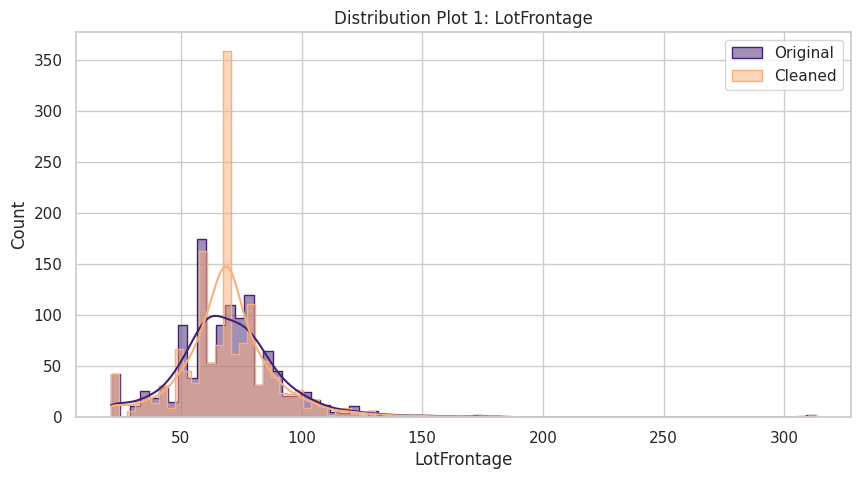

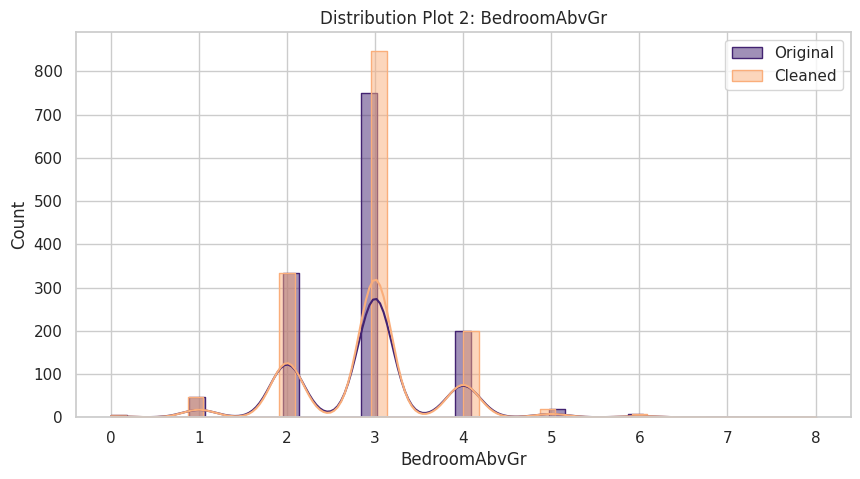

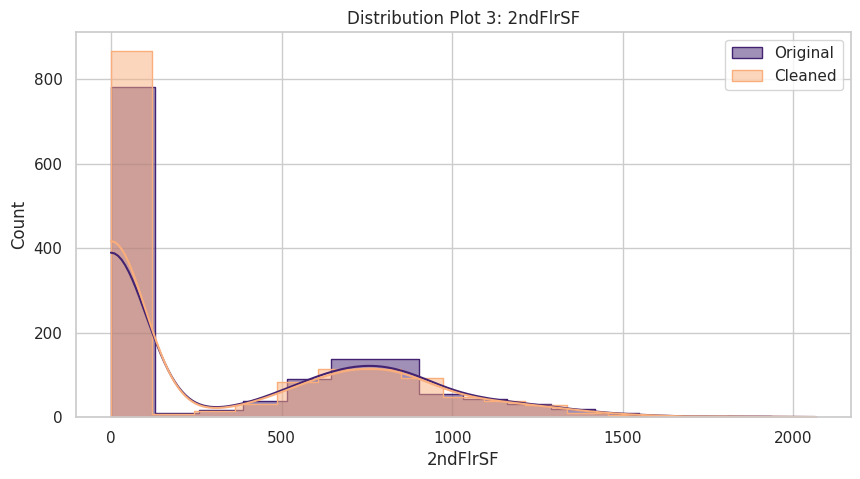

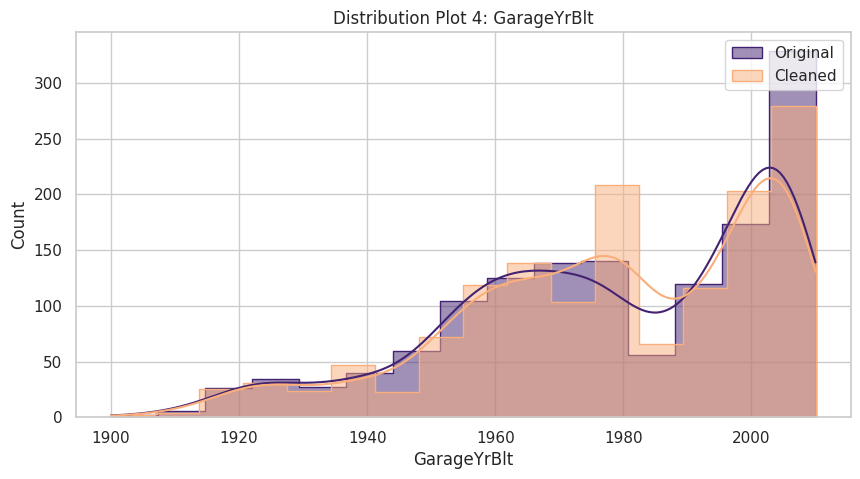

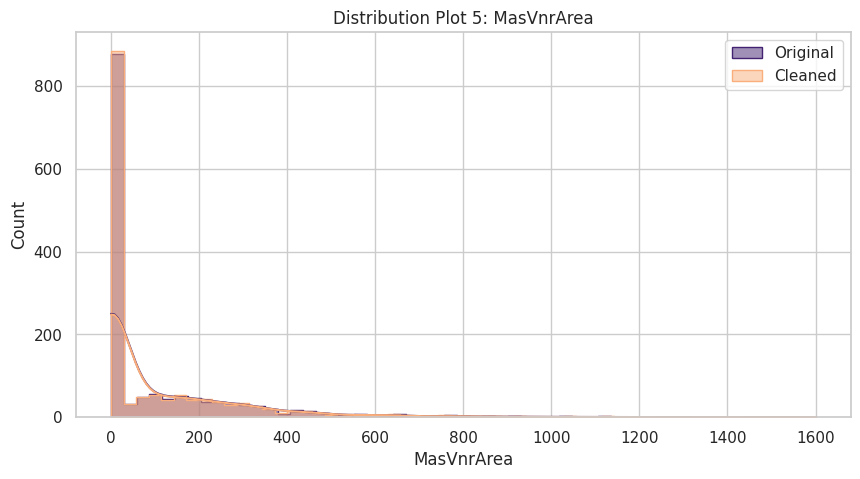

In [11]:
from feature_engine.imputation import MeanMedianImputer

variables_median = [
    'LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea'
    ]
imputer = MeanMedianImputer(
    imputation_method='median', variables=variables_median
    )
df_method = imputer.fit_transform(house_prices_df)
DataCleaningEffect(df_original=house_prices_df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_median)


In reviewing this data we can observe the below. 

1. LotFrontage - The imputation has added variables in the 60 - 70 range, significantly affecting the range between the lowest and highest amount.
2. BedroomAbvGr - The imputation has added rooms in the 3 bedroom ranges.
3. 2ndFlrSF - The imputation has added missing data in both the 0 and the 500 - 100 range. This follows the trends 4.in the original data so is acceptable.
4. GarageYrBlt - There is some difference in the data between 1970 and 1980.
5. MasVnrArea - The cleaned and original data closely match.

While there are obviously some effects on the data set, none of the imputations affect the distribution of the data. As such the risks to the reliability of our model and data study are outweighed by the advantages having a significantly larger data study has. We should remember we have done this however, and can revisit these observations at a later stage if we need to.

We can assign the output to the variable below and check the update has worked.

In [12]:
house_prices_df = df_method
df_missing_data = EvaluateMissingData(house_prices_df)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data


* There are 2 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object


### Batch 2 - GarageFinish, BsmtFinType1.

We can use the same visualisations to see the effect of imputations on the catagorical variables. It is possible that the missing data represents an absence of the feature all together (e.g. houses without a garage or a finished basement), so we will see the effect of imputing these categories as 'none'. As these are catagorical variables we will need to use a catgorical imputer. 


* Distribution Effect Analysis After Data Cleaning Methodin the following variables:
['GarageFinish', 'BsmtFinType1'] 




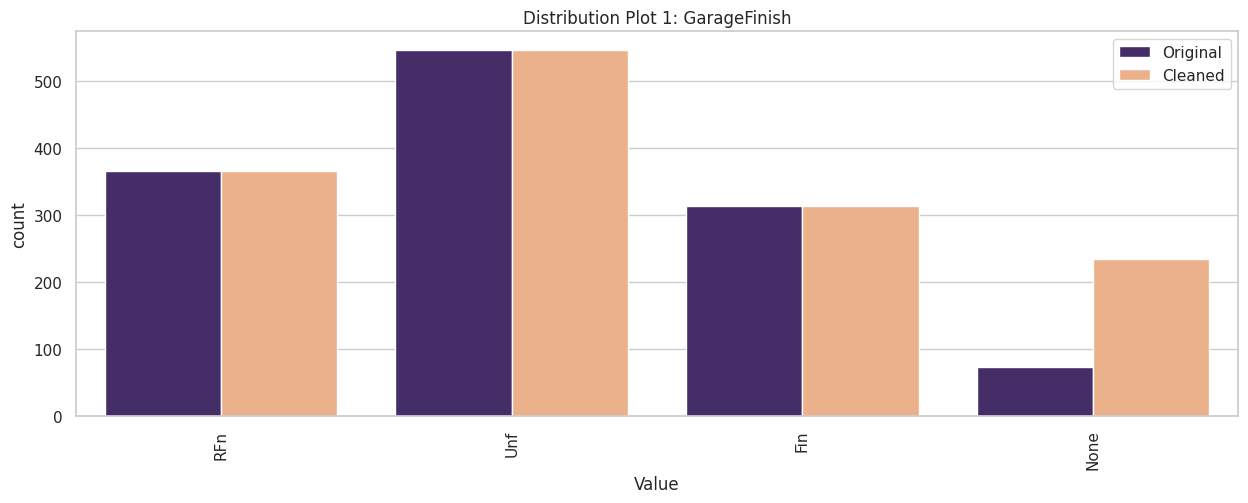

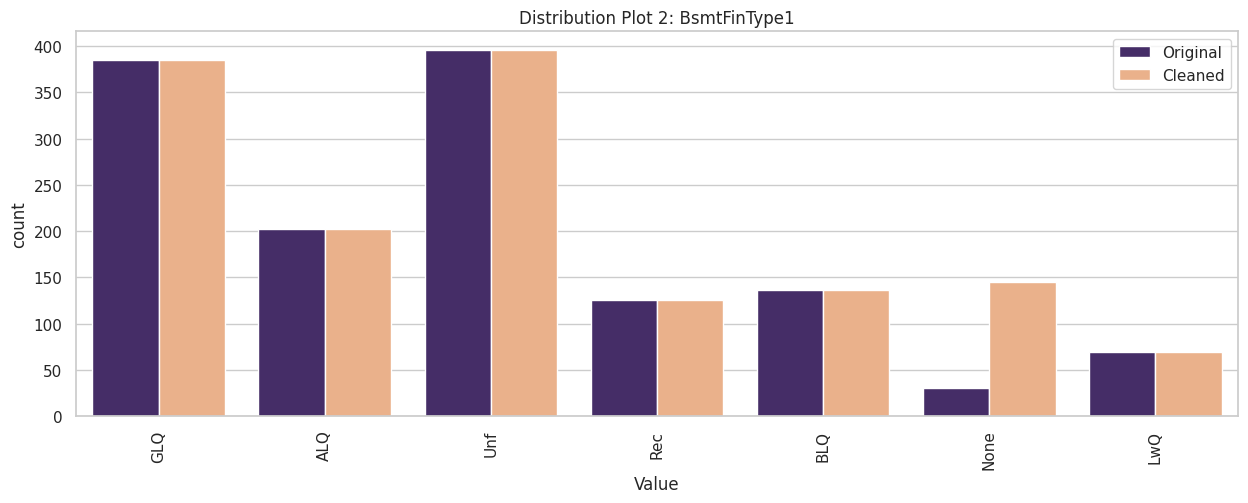

In [13]:
from feature_engine.imputation import CategoricalImputer

variables_categorical = ['GarageFinish', 'BsmtFinType1']
imputer = CategoricalImputer(
    imputation_method='missing',
    fill_value='None',
    variables=variables_categorical
    )
df_method = imputer.fit_transform(house_prices_df)
DataCleaningEffect(df_original=house_prices_df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_categorical)


This approach had little effect on the data's overall distribution so we will apply this method to our data.

Again, we can assign the output to the variable below and check the update has worked.

In [14]:
house_prices_df = df_method
df_missing_data = EvaluateMissingData(house_prices_df)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data


* There are 0 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType


In [15]:
house_prices_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1460 non-null   int64  
 1   2ndFlrSF      1460 non-null   float64
 2   BedroomAbvGr  1460 non-null   float64
 3   BsmtExposure  1460 non-null   object 
 4   BsmtFinSF1    1460 non-null   int64  
 5   BsmtFinType1  1460 non-null   object 
 6   BsmtUnfSF     1460 non-null   int64  
 7   GarageArea    1460 non-null   int64  
 8   GarageFinish  1460 non-null   object 
 9   GarageYrBlt   1460 non-null   float64
 10  GrLivArea     1460 non-null   int64  
 11  KitchenQual   1460 non-null   object 
 12  LotArea       1460 non-null   int64  
 13  LotFrontage   1460 non-null   float64
 14  MasVnrArea    1460 non-null   float64
 15  OpenPorchSF   1460 non-null   int64  
 16  OverallCond   1460 non-null   int64  
 17  OverallQual   1460 non-null   int64  
 18  TotalBsmtSF   1460 non-null 

---

# Push files to Repo

* Creating a new folder to save the cleaned data to.

In [19]:
import os
try:
    os.makedirs(name='outputs/datasets/clean_data')
except Exception as e:
    print(e)

house_prices_df.to_csv(
    f"outputs/datasets/clean_data/House_prices_records_clean.csv", index=False
    )
inherited_houses_df.to_csv(
    f"outputs/datasets/clean_data/Inherited_houses_clean.csv", index=False
    )
